100%|██████████| 170M/170M [00:18<00:00, 9.06MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Epoch 1/15, Train Loss: 1.2138, Train Acc: 58.75%, Val Loss: 1.0627, Val Acc: 64.48%
Epoch 2/15, Train Loss: 0.8582, Train Acc: 71.10%, Val Loss: 0.8593, Val Acc: 69.77%
Epoch 3/15, Train Loss: 0.7768, Train Acc: 73.43%, Val Loss: 0.7477, Val Acc: 75.00%
Epoch 4/15, Train Loss: 0.6791, Train Acc: 76.93%, Val Loss: 0.6836, Val Acc: 76.29%
Epoch 5/15, Train Loss: 0.6633, Train Acc: 77.30%, Val Loss: 0.6707, Val Acc: 77.06%
Epoch 6/15, Train Loss: 0.6051, Train Acc: 79.21%, Val Loss: 0.6447, Val Acc: 78.36%
Epoch 7/15, Train Loss: 0.5624, Train Acc: 80.60%, Val Loss: 0.6440, Val Acc: 78.99%
Epoch 8/15, Train Loss: 0.5501, Train Acc: 81.01%, Val Loss: 0.5651, Val Acc: 80.79%
Epoch 9/15, Train Loss: 0.5235, Train Acc: 81.93%, Val Loss: 0.5785, Val Acc: 80.19%
Epoch 10/15, Train Loss: 0.5053, Train Acc: 82.57%, Val Loss: 0.5606, Val Acc: 80.71%
Epoch 11/15, Train Loss: 0.4768, Train Acc: 83.42%, Val Loss: 0.5737, Val Acc: 80.87%
Epoch 12/15, Train Loss: 0.4639, Train Acc: 83.88%, Val Loss: 0

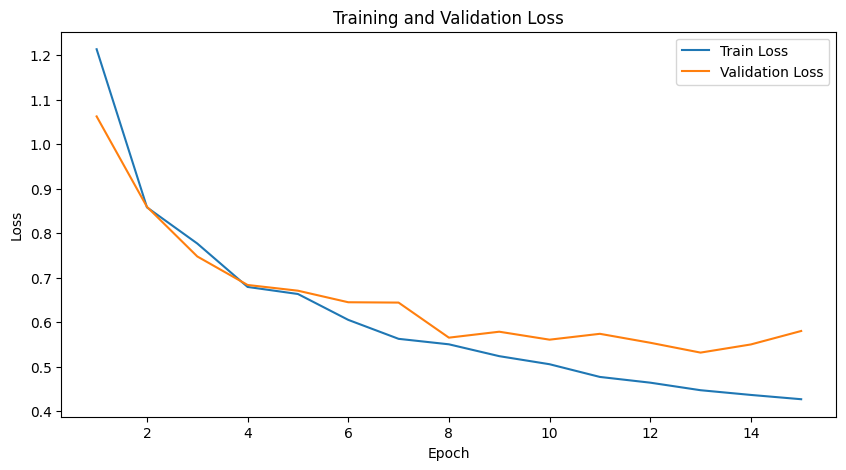

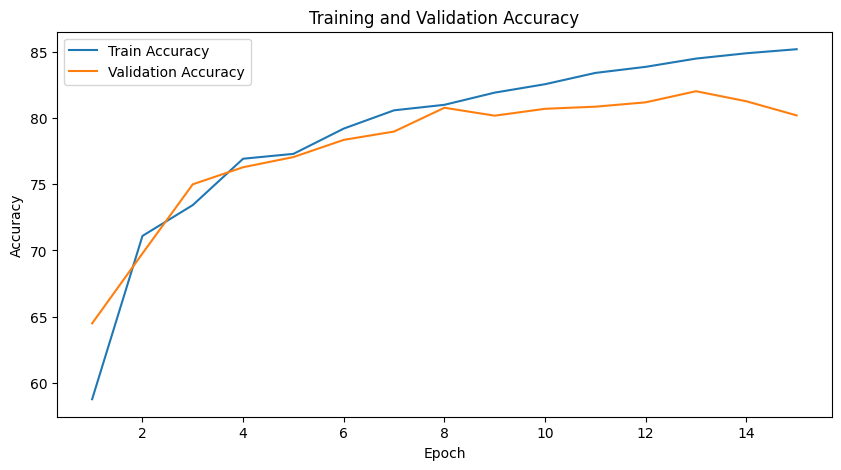

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # additional data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained ResNet-18 model and modify output layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Define loss function and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD with momentum

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Training and validation loop with 15 epochs
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
